<a href="https://colab.research.google.com/github/cs20m016/cs6910-Assignment-1/blob/main/Gradient_Descent_Solution%5B1-7%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -qq
import wandb

     |████████████████████████████████| 2.0MB 5.5MB/s 
     |████████████████████████████████| 163kB 25.8MB/s 
     |████████████████████████████████| 102kB 9.3MB/s 
     |████████████████████████████████| 133kB 22.9MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 


In [2]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
from random import random
import math
from sklearn.utils import shuffle
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
train_data,test_data=fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
class_label=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [6]:
train_Xi, trainy= train_data
test_Xi, testY = test_data
train_X,test_X=prep_pixels(train_Xi,test_Xi)
train_X, trainy = shuffle(train_X, trainy)
test_X, testY = shuffle(test_X, testY)

In [7]:
sample=[]
for label in range(10):
    for i in range(len(testY)):
        if label==testY[i]:
            sample.append(test_X[i])
            break
#No of classes
K=len(sample)

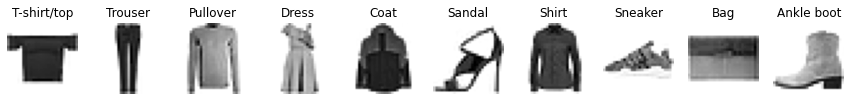

In [8]:
fig=plt.figure(figsize=(15,15))
rows=1
columns=10
for i in range(1, columns*rows +1):
    tg=sample[i-1]
    ax=fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(tg,cmap=plt.cm.binary)
    ax.title.set_text(class_label[i-1])
plt.show()

In [9]:
wandb.init(project="demo")
wandb.log({"Examples": [wandb.Image(img, caption=cap) for img,cap in zip(sample,class_label)]})

wandb: Currently logged in as: athirapt (use `wandb login --relogin` to force relogin)


In [10]:
trainx=[train_X[i].flatten() for i in range(len(train_X))]
testX=[test_X[i].flatten() for i in range(len(test_X))]
xlen=len(trainx[0])

In [11]:
trainX,validX,trainY,validY=train_test_split(trainx,trainy,test_size = 0.1,train_size =0.9)
train_samples=len(trainX)
valid_samples=len(validX)
test_samples=len(testX)
print('Train:',np.shape(trainX),np.shape(trainY))
print('Valid:',np.shape(validX),np.shape(validY))
print('Test:',np.shape(testX),np.shape(testY))

Train: (54000, 784) (54000,)
Valid: (6000, 784) (6000,)
Test: (10000, 784) (10000,)


In [12]:
def initialize_weights_random(n_input, n_hidden_layer, n_output,neurons_hl):
    W = list()
    W.append([[np.random.normal() for j in range(n_input)]for i in range(neurons_hl)])
    for i in range(n_hidden_layer-1):
        W.append([[np.random.normal() for j in range(neurons_hl)]for i in range(neurons_hl)])
    W.append([[np.random.normal() for j in range(neurons_hl)]for i in range(n_output)])
    return W


def initialize_bias_random(n_input, n_hidden_layer, n_output,neurons_hl):
    B=list()
    for i in range(n_hidden_layer):
        B.append([np.random.normal() for i in range(neurons_hl)])
    B.append([np.random.normal() for i in range(n_output)])
    return B


def initialize_weights_xavier(n_input, n_hidden_layer, n_output,neurons_hl):
    W = list()
    W.append([[np.random.normal(0,1/n_input) for j in range(n_input)]for i in range(neurons_hl)])
    for i in range(n_hidden_layer-1):
        W.append([[np.random.normal(0,1/neurons_hl) for j in range(neurons_hl)]for i in range(neurons_hl)])
    W.append([[np.random.normal(0,1/neurons_hl) for j in range(neurons_hl)]for i in range(n_output)])
    return W


def initialize_bias_xavier(n_input, n_hidden_layer, n_output,neurons_hl):
    B=list()
    for i in range(n_hidden_layer):
        B.append([0 for i in range(neurons_hl)])
    B.append([0 for i in range(n_output)])
    return B

def initialize_zero_weights(n_input, n_hidden_layer, n_output,neurons_hl):
    W = list()
    W.append([[0 for j in range(n_input)]for i in range(neurons_hl)])
    for i in range(n_hidden_layer-1):
        W.append([[0 for j in range(neurons_hl)]for i in range(neurons_hl)])
    W.append([[0 for j in range(neurons_hl)]for i in range(n_output)])
    return W

def initialize_zero_bias(n_input, n_hidden_layer, n_output,neurons_hl):
    B=list()
    for i in range(n_hidden_layer):
        B.append([0 for i in range(neurons_hl)])
    B.append([0 for i in range(n_output)])
    return B

def initialize(s,n_input, n_hidden_layer, n_output,neurons_hl):
  if s=='random':
    W=initialize_weights_random(n_input, n_hidden_layer, n_output,neurons_hl)
    B=initialize_bias_random(n_input, n_hidden_layer, n_output,neurons_hl)
  else:
    W=initialize_weights_xavier(n_input, n_hidden_layer, n_output,neurons_hl)
    B=initialize_bias_xavier(n_input, n_hidden_layer, n_output,neurons_hl)
  return W,B

In [13]:
def activation(s,b):
  a=np.array(b,dtype=np.float128)
  if s=='sigmoid':
    return sigmoid(a)
  elif s=='tanh':
    return tanH(a)
  elif s=='relu':
    return reLu(a)
  return

def diff(s,a):
  if s=='sigmoid':
    return diff_sigmoid(a)
  elif s=='tanh':
    return diff_tanh(a)
  elif s=='relu':
    return diff_relu(a)
  return

def reLu(b):
  a=np.array(b,dtype=np.float128)
  return np.maximum(a,0)

def diff_relu(a):
  res=list()
  for el in a:
    if el<0:
      res.append(0)
    else:
      res.append(1)
  return res

def tanH(b):
  a=np.array(b,dtype=np.float128)
  res=list()
  res=np.tanh(a)
  return res

def diff_tanh(a):
  res=list()
  for el in a:
    res.append(1-(np.tanh(el))**2)
  return res

def sigmoid(b):
  a=np.array(b,dtype=np.float128)
  h=list()
  for el in a:
    z=1/(1+math.exp(-el))
    h.append(z)
  return h

def diff_sigmoid(a):
   res=list()
   for el in a:
     res.append(cmp(el))
   return res

def cmp(e):
  g=1/(1+np.exp(-e))
  return g*(1-g)

In [14]:
def softmax(b):
  a=np.array(b,dtype=np.float128)
  z = a - max(a)
  h=list()
  sum=0
  for el in z:
    sum+=np.exp(el)
  for el in z:
    h.append(np.exp(el)/sum)
  return h

In [ ]:
#Wx,Bx=initialize('random',len(trainX[0]),4,10,12)

In [15]:
def feed_forward(input,W,B,L,actfn):
    H=list()
    A=list()
    H.append(input)
    A.append([0])
    for i in range(1,L):
        a=B[i-1]+np.matmul(W[i-1],H[i-1])
        A.append(a)
        h=activation(actfn,a)
        H.append(h)
    a=B[L-1]+np.matmul(W[L-1],H[L-1])
    A.append(a)
    hL=softmax(a)
    H.append(hL)
    return H,A,hL

In [ ]:
#Hx,Ax,yx=feed_forward(trainX[992],Wx,Bx,5,'relu')
#yx

In [16]:
def back_propogation(H,A,y_hat,label,W,L,actfn):
    W_grad=list()
    B_grad=list()
    one_hot_y=np.zeros(K)
    one_hot_y[label]+=1
    ak_grad = y_hat-one_hot_y
    for k in range(L,0,-1):
        w_grad=np.matmul(np.matrix(ak_grad).T,np.matrix(H[k-1]))
        W_grad.append(w_grad)
        B_grad.append(ak_grad)
        if k != 1:
            h_grad=np.matmul(np.transpose(W[k-1]),ak_grad)
            ak_grad=np.multiply(h_grad,diff(actfn,A[k-1]))
    return W_grad,B_grad

In [17]:
def stochastic(L,N,eta,epoch,actfn,initop,decay):
    e=0
    error=0.0
    W,B=initialize(initop,xlen,L-1,K,N)
    loss=list()
    while (e<epoch):
        for i in range(train_samples):
            H,A,y_hat=feed_forward(trainX[i],W,B,L,actfn)
            ei=y_hat[trainY[i]]
            if ei!=0:
                loss.append(-math.log(ei+1e-7))     
            W_grad,B_grad=back_propogation(H,A,y_hat,trainY[i],W,L,actfn)
            W_grad=W_grad[::-1]
            B_grad=B_grad[::-1]
            for l in range(L):
                W[l]=(np.multiply(1-decay,W[l])-np.multiply(eta,W_grad[l])).tolist()
                B[l]=np.subtract(np.multiply(1-decay,B[l]),np.multiply(eta,B_grad[l])).tolist()       
        e=e+1
        wandb.log({'epoch':e})
        print('Epoch',e)
    return W,B,loss

def momentum(L,N,eta,batch_size,epoch,actfn,initop,decay):
    t,e= 0,0
    W,B=initialize(initop,xlen,L-1,K,N)
    points= 0
    error= 0.0
    gamma= 0.9
    loss=list()
    wgrad=list()
    bgrad=list()
    for l in range(L):
        wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
        bgrad.append(np.zeros(shape=np.shape(B[l])).tolist())
    uw=list()
    ub=list()
    for l in range(L):
        uw.append(np.zeros(shape=np.shape(W[l])).tolist())
        ub.append(np.zeros(shape=np.shape(B[l])).tolist())
    while (e<epoch):
        for i in range(train_samples):
            H,A,y_hat=feed_forward(trainX[i],W,B,L,actfn)
            ei=y_hat[trainY[i]]
            if ei!=0:
                error += -math.log(ei+1e-7)
            W_grad,B_grad=back_propogation(H,A,y_hat,trainY[i],W,L,actfn)
            W_grad=W_grad[::-1]
            B_grad=B_grad[::-1]
            for l in range(L):
                wgrad[l]=(np.matrix(wgrad[l])+np.matrix(W_grad[l])).tolist()
                bgrad[l]=(bgrad[l]+np.multiply(1,B_grad[l])).tolist()
            points+=1
            if(points%batch_size==0):
                points=0
                t += 1
                loss.append(error/batch_size)
                error=0.0
                for l in range(L):
                    uw[l]=(np.multiply(gamma,uw[l])+np.multiply(eta,wgrad[l])).tolist()
                    W[l]=np.subtract(np.multiply(1-decay,W[l]),uw[l]).tolist()
                    ub[l]=(np.multiply(gamma,ub[l])+np.multiply(eta,bgrad[l])).tolist()
                    B[l]=np.subtract(np.multiply(1-decay,B[l]),ub[l]).tolist()
                wgrad=list()
                bgrad=list()
                for l in range(L):
                    wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
                    bgrad.append(np.zeros(shape=np.shape(B[l])).tolist())            
        e=e+1
        wandb.log({'epoch':e})
        print('Epoch',e)
    return W,B,loss

def nesterov(L,N,eta,batch_size,epoch,actfn,initop,decay):
    e,t=0,0
    W,B=initialize(initop,xlen,L-1,K,N)
    loss=list()
    points=0
    error=0.0
    gamma=0.9
    wgrad=list()
    bgrad=list()
    for l in range(L):
        wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
        bgrad.append(np.zeros(shape=np.shape(B[l])).tolist())
    uw=list()
    ub=list()
    for l in range(L):
        uw.append(np.zeros(shape=np.shape(W[l])).tolist())
        ub.append(np.zeros(shape=np.shape(B[l])).tolist())
    while (e<epoch):
        for i in range(train_samples):
            Wc=list()
            Bc=list()
            for l in range(L):
                Wc.append((W[l]-np.multiply(gamma,uw[l])).tolist())
                Bc.append((B[l]-np.multiply(gamma,ub[l])).tolist())
            H,A,y_hat=feed_forward(trainX[i],W,B,L,actfn)
            ei=y_hat[trainY[i]]
            if ei!=0:
                error += -math.log(ei+1e-7)
            Hi,Ai,y_hati=feed_forward(trainX[i],Wc,Bc,L,actfn)
            W_grad,B_grad=back_propogation(Hi,Ai,y_hati,trainY[i],Wc,L,actfn)
            W_grad=W_grad[::-1]
            B_grad=B_grad[::-1]
            for l in range(L):
                wgrad[l]=(np.matrix(wgrad[l])+np.matrix(W_grad[l])).tolist()
                bgrad[l]=(bgrad[l]+np.multiply(1,B_grad[l])).tolist()
            points+=1
            if(points%batch_size==0):
                points=0
                t += 1
                loss.append(error/batch_size)
                error=0.0
                for l in range(L):
                    uw[l]=(np.multiply(gamma,uw[l])+np.multiply(eta,wgrad[l])).tolist()
                    W[l]=np.subtract(np.multiply(1-decay,W[l]),uw[l]).tolist()
                    ub[l]=(np.multiply(gamma,ub[l])+np.multiply(eta,bgrad[l])).tolist()
                    B[l]=np.subtract(np.multiply(1-decay,B[l]),ub[l]).tolist()
                wgrad=list()
                bgrad=list()
                for l in range(L):
                    wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
                    bgrad.append(np.zeros(shape=np.shape(B[l])).tolist())         
        e=e+1
        wandb.log({'epoch':e})
        print('Epoch',e)
    return W,B,loss

def rmsprop(L,N,eta,batch_size,epoch,actfn,initop,decay):
    t=0
    W,B=initialize(initop,xlen,L-1,K,N)
    loss=list()
    points=0
    error=0.0
    epsilon=1e-10
    beta=0.98
    wgrad=list()
    bgrad=list()
    for l in range(L):
        wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
        bgrad.append(np.zeros(shape=np.shape(B[l])).tolist())
    v_w=list()
    v_b=list()
    for l in range(L):
        v_w.append(np.zeros(shape=np.shape(W[l])).tolist())
        v_b.append(np.zeros(shape=np.shape(B[l])).tolist())
    while (t<epoch):
        for i in range(train_samples):
            H,A,y_hat=feed_forward(trainX[i],W,B,L,actfn)
            ei=y_hat[trainY[i]]
            if ei!=0:
                error += -math.log(ei+1e-7)
            W_grad,B_grad=back_propogation(H,A,y_hat,trainY[i],W,L,actfn)
            W_grad=W_grad[::-1]
            B_grad=B_grad[::-1]
            for l in range(L):
                wgrad[l]=(np.matrix(wgrad[l])+np.matrix(W_grad[l])).tolist()
                bgrad[l]=(bgrad[l]+np.multiply(1,B_grad[l])).tolist()
            points+=1
            if(points%batch_size==0):
                points=0
                loss.append(error/batch_size)
                error=0.0
                for l in range(L):
                    v_w[l]=(np.multiply(beta,v_w[l])+np.multiply((1-beta),np.square(wgrad[l]))).tolist()
                    tmp=v_w[l].copy()
                    new_t=np.add(epsilon,tmp).tolist()
                    rl=np.reciprocal([[float(j) for j in i] for i in np.sqrt(new_t)]).tolist()
                    W[l]=(np.multiply(1-decay,W[l])-np.multiply(wgrad[l],np.multiply(eta,rl))).tolist()
                    v_b[l]=(np.multiply(beta,v_b[l])+np.multiply((1-beta),np.square(bgrad[l]))).tolist()
                    tmp1=v_b[l].copy()
                    new_t1=np.add(epsilon,tmp1).tolist()
                    rl1=np.reciprocal([float(i) for i in np.sqrt(new_t1)]).tolist()
                    B[l]=np.subtract(np.multiply(1-decay,B[l]),np.multiply(bgrad[l],np.multiply(eta,rl1))).tolist()
                wgrad=list()
                bgrad=list()
                for l in range(L):
                    wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
                    bgrad.append(np.zeros(shape=np.shape(B[l])).tolist())            
        t=t+1
        wandb.log({'epoch':t})
        print('Epoch',t)
    return W,B,loss

def adam(L,N,eta,batch_size,epoch,actfn,initop,decay):
    t,e=0,0
    W,B=initialize(initop,xlen,L-1,K,N)
    loss=list()
    points=0
    error=0.0
    epsilon=1e-10
    beta1=0.9
    beta2=0.999
    wgrad=list()
    bgrad=list()
    for l in range(L):
        wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
        bgrad.append(np.zeros(shape=np.shape(B[l])).tolist())
    v_w=list()
    v_b=list()
    for l in range(L):
        v_w.append(np.zeros(shape=np.shape(W[l])).tolist())
        v_b.append(np.zeros(shape=np.shape(B[l])).tolist())
    m_w=list()
    m_b=list()
    for l in range(L):
        m_w.append(np.zeros(shape=np.shape(W[l])).tolist())
        m_b.append(np.zeros(shape=np.shape(B[l])).tolist())
    while (e<epoch):
        for i in range(train_samples):
            H,A,y_hat=feed_forward(trainX[i],W,B,L,actfn)
            ei=y_hat[trainY[i]]
            if ei!=0:
                error += -math.log(ei+1e-7)
            W_grad,B_grad=back_propogation(H,A,y_hat,trainY[i],W,L,actfn)
            W_grad=W_grad[::-1]
            B_grad=B_grad[::-1]
            for l in range(L):
                wgrad[l]=(np.matrix(wgrad[l])+np.matrix(W_grad[l])).tolist()
                bgrad[l]=(bgrad[l]+np.multiply(1,B_grad[l])).tolist()
            points+=1
            if(points%batch_size==0):
                t+=1
                points=0
                loss.append(error/batch_size)
                error=0.0
                for l in range(L):
                    m_w[l]=(np.multiply(beta1,m_w[l])+np.multiply((1-beta1),wgrad[l])).tolist()
                    mwe=(np.divide(m_w[l],(1-(beta1**t)))).tolist()
                    v_w[l]=(np.multiply(beta2,v_w[l])+np.multiply((1-beta2),np.square(wgrad[l]))).tolist()
                    vwe=(np.divide(v_w[l],(1-(beta2**t)))).tolist()
                    tmp=vwe.copy()
                    new_t=np.add(epsilon,tmp).tolist()
                    rl=np.reciprocal([[float(j) for j in i] for i in np.sqrt(new_t)]).tolist()
                    W[l]=(np.multiply(1-decay,W[l])-np.multiply(mwe,np.multiply(eta,rl))).tolist()
                    m_b[l]=(np.multiply(beta1,m_b[l])+np.multiply((1-beta1),bgrad[l])).tolist()
                    mbe=(np.divide(m_b[l],(1-(beta1**t)))).tolist()
                    v_b[l]=(np.multiply(beta2,v_b[l])+np.multiply((1-beta2),np.square(bgrad[l]))).tolist()
                    vbe=(np.divide(v_b[l],(1-(beta2**t)))).tolist()
                    tmp1=vbe.copy()
                    new_t1=np.add(epsilon,tmp1).tolist()
                    rl1=np.reciprocal([float(i) for i in np.sqrt(new_t1)]).tolist()
                    B[l]=np.subtract(np.multiply(1-decay,B[l]),np.multiply(mbe,np.multiply(eta,rl1))).tolist()              
                wgrad=list()
                bgrad=list()
                for l in range(L):
                    wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
                    bgrad.append(np.zeros(shape=np.shape(B[l])).tolist()) 
        e=e+1
        wandb.log({'epoch':e})
        print('Epoch',e)
    return W,B,loss

def nadam(L,N,eta,batch_size,epoch,actfn,initop,decay):
    t,e=0,0
    W,B=initialize(initop,xlen,L-1,K,N)
    loss=list()
    points=0
    error=0.0
    epsilon=1e-10
    beta1=0.9
    beta2=0.999
    wgrad=list()
    bgrad=list()
    for l in range(L):
        wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
        bgrad.append(np.zeros(shape=np.shape(B[l])).tolist())
    v_w=list()
    v_b=list()
    for l in range(L):
        v_w.append(np.zeros(shape=np.shape(W[l])).tolist())
        v_b.append(np.zeros(shape=np.shape(B[l])).tolist())
    m_w=list()
    m_b=list()
    for l in range(L):
        m_w.append(np.zeros(shape=np.shape(W[l])).tolist())
        m_b.append(np.zeros(shape=np.shape(B[l])).tolist())
    while (e<epoch):
        for i in range(train_samples):
            H,A,y_hat=feed_forward(trainX[i],W,B,L,actfn)
            ei=y_hat[trainY[i]]
            if ei!=0:
                error += -math.log(ei+1e-7)
            W_grad,B_grad=back_propogation(H,A,y_hat,trainY[i],W,L,actfn)
            W_grad=W_grad[::-1]
            B_grad=B_grad[::-1]
            for l in range(L):
                wgrad[l]=(np.matrix(wgrad[l])+np.matrix(W_grad[l])).tolist()
                bgrad[l]=(bgrad[l]+np.multiply(1,B_grad[l])).tolist()
            points+=1
            if(points%batch_size==0):
                t+=1
                points=0
                loss.append(error/batch_size)
                error=0.0
                for l in range(L):
                    m_w[l]=(np.multiply(beta1,m_w[l])+np.multiply((1-beta1),wgrad[l])).tolist()
                    mwe=(np.divide(m_w[l],(1-(beta1**t)))).tolist()
                    v_w[l]=(np.multiply(beta2,v_w[l])+np.multiply((1-beta2),np.square(wgrad[l]))).tolist()
                    vwe=(np.divide(v_w[l],(1-(beta2**t)))).tolist()
                    tmp=vwe.copy()
                    new_t=np.add(epsilon,tmp).tolist()
                    rl=np.reciprocal([[float(j) for j in i] for i in np.sqrt(new_t)]).tolist()
                    mwe_up=(np.multiply(beta1,m_w[l])+np.multiply(((1-beta1)/(1-(beta1**t))),wgrad[l])).tolist()
                    W[l]=(np.multiply(1-decay,W[l])-np.multiply(mwe_up,np.multiply(eta,rl))).tolist()
                    m_b[l]=(np.multiply(beta1,m_b[l])+np.multiply((1-beta1),bgrad[l])).tolist()
                    mbe=(np.divide(m_b[l],(1-(beta1**t)))).tolist()
                    v_b[l]=(np.multiply(beta2,v_b[l])+np.multiply((1-beta2),np.square(bgrad[l]))).tolist()
                    vbe=(np.divide(v_b[l],(1-(beta2**t)))).tolist()
                    tmp1=vbe.copy()
                    new_t1=np.add(epsilon,tmp1).tolist()
                    rl1=np.reciprocal([float(i) for i in np.sqrt(new_t1)]).tolist()
                    mbe_up=(np.multiply(beta1,m_b[l])+np.multiply(((1-beta1)/(1-(beta1**t))),bgrad[l])).tolist()
                    B[l]=np.subtract(np.multiply(1-decay,B[l]),np.multiply(mbe_up,np.multiply(eta,rl1))).tolist()              
                wgrad=list()
                bgrad=list()
                for l in range(L):
                    wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
                    bgrad.append(np.zeros(shape=np.shape(B[l])).tolist()) 
        e=e+1
        wandb.log({'epoch':e})
        print('Epoch',e)
    return W,B,loss


In [22]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epoch': {
            'values': [3,4,5,10]
        },
        'layers':{
            'values': [4,5,6]
        },
        'hidden_layer_size' :{
            'values': [12,24,32,64,128]
        },
        'weight_decay':{
            'values': [0,0.0005,0.5,0.05]
        },
        'learning_rate':{
            'values': [0.001,0.0001]
        },
        'optimizer_fn':{
            'values': ['sgd','momentum','nesterov','rmsprop','adam','nadam']
        },
        'batch_size': {
            'values': [16,32,64,128]
        },
        'weight_initial':{
            'values': ['random','xavier']
        },
        'activation_fn':{
            'values': ['sigmoid','tanh','relu']
        }
    }
}

In [19]:
sweep_id = wandb.sweep(sweep_config,project="A1")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: o2y0qj8y
Sweep URL: https://wandb.ai/athirapt/A1/sweeps/o2y0qj8y


In [20]:
# The sweep calls this function with each set of hyperparameters
def train():
    config_defaults={
        'epoch':2,
        'layers':2,
        'hidden_layer_size':3,
        'weight_decay':0.0005,
        'learning_rate':0.001,
        'optimiser_fn':'nesterov',
        'batch_size':16,
        'weight_initial':'random',
        'activation_fn':'tanh'
        }
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    L=config.layers
    N=config.hidden_layer_size
    batch=config.batch_size
    epoch=config.epoch
    acon=config.activation_fn
    initial=config.weight_initial
    optimiser=config.optimiser_fn
    eta=config.learning_rate
    decay=config.weight_decay

    W_r= initialize_weights_random(len(trainX[0]),L-1,K,N)
    B_r= initialize_bias_random(len(trainX[0]),L-1,K,N)

    if optimiser=='sgd':
        W_r,B_r,loss=stochastic(L,N,eta,epoch,acon,initial,decay)
    elif optimiser=='momentum':
        W_r,B_r,loss=momentum(L,N,eta,batch,epoch,acon,initial,decay)
    elif optimiser=='nesterov':
        W_r,B_r,loss=nesterov(L,N,eta,batch,epoch,acon,initial,decay)
    elif optimiser=='rmsprop':
        W_r,B_r,loss=rmsprop(L,N,eta,batch,epoch,acon,initial,decay)
    elif optimiser=='adam':
        W_r,B_r,loss=adam(L,N,eta,batch,epoch,acon,initial,decay)
    else:
        W_r,B_r,loss=nadam(L,N,eta,batch,epoch,acon,initial,decay)


    validation_valid=0
    validation_predict=list()
    validation_error=0.0
    for i in range(valid_samples):
        H,A,y_hat = feed_forward(validX[i],W_r,B_r,L,acon)
        class_vpredict = np.argmax(y_hat)
        ei=y_hat[validY[i]]
        if ei!=0:
            validation_error += -math.log(ei)
        validation_predict.append(class_vpredict)
        if class_vpredict == validY[i]:
            validation_valid+=1
        if i%config.batch_size==0:
            wandb.log({'val_accuracy': validation_valid/(i+1)})
            wandb.log({'val_loss': validation_error/(i+1)})
    valid_acc=validation_valid/valid_samples


    test_valid=0
    test_predict=[]
    test_error=0.0
    for i in range(test_samples):
        H,A,y_hat = feed_forward(testX[i],W_r,B_r,L,acon)
        class_predict = np.argmax(y_hat)
        ei=y_hat[testY[i]]
        if ei!=0:
            test_error += -math.log(ei)
        test_predict.append(class_predict)
        if class_predict == testY[i]:
            test_valid+=1
        if i%config.batch_size==0:
            wandb.log({'accuracy': test_valid/(i+1)})
            wandb.log({'loss': test_error/(i+1)})
    test_acc=test_valid/test_samples
    wandb.log({'accuracy': test_acc})
    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,y_true=testY, preds=test_predict,class_names=class_label)})
    print(test_acc)
    return

In [21]:
wandb.agent(sweep_id, train,count=80)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: loprlw8j with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	epoch: 3
wandb: 	hidden_layer_size: 12
wandb: 	layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimizer_fn: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_initial: xavier


Epoch 1
Epoch 2
Epoch 3
0.8042


epoch,3
_runtime,1485
_timestamp,1615815185
_step,2004
val_accuracy,0.81537
val_loss,0.51576
accuracy,0.8042
loss,0.56236


epoch,▁▅█
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,█▆▄▄▅▂▄▁▁▂▃▃▃▃▃▃▂▃▃▃▃▄▄▄▄▄▃▃▃▃▃▄▄▄▄▄▄▄▄▄
val_loss,▁▄█▇▄▆▃▅▅▅▄▄▄▄▄▄▅▅▅▅▅▄▄▄▄▅▅▅▅▅▅▄▅▅▅▅▅▅▄▄
accuracy,▃▁█▅▆▅▅▅▆▇▇▇▇▆▇▇▆▇▆▆▆▆▆▆▆▆▆▆▆▇▆▆▇▆▆▆▇▇▇▇
loss,▂█▂▄▄▄▄▃▃▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂


wandb: Agent Starting Run: yngt270c with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 16
wandb: 	epoch: 3
wandb: 	hidden_layer_size: 24
wandb: 	layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimizer_fn: adam
wandb: 	weight_decay: 0
wandb: 	weight_initial: xavier


wandb: Ctrl + C detected. Stopping sweep.
